# Portfolio Optimization

In [7]:
!pip install yfinance
!pip install cvxpy

  Using cached clarabel-0.10.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
  Using cached scs-3.2.7.post2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.0 MB/s eta 0:00:00
Using cached clarabel-0.10.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
Using cached scs-3.2.7.post2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.4 MB)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import cvxpy as cp

## Class definition

In [9]:
class Portfolio:
    def __init__(self, assets, period="10y", q=10):
        """
        Initialize the Portfolio class with assets and settings.
        Args:
            assets (list): List of asset tickers.
            period (str): Historical data period (default is "10y").
            q (float): Risk aversion parameter (default is 10).
        """
        self.assets = assets
        self.period = period
        self.q = q
        self.n = len(assets)
        self.sigma = None
        self.r = None
        self._calculate_statistics()

    def _calculate_statistics(self):
        """
        Calculate the covariance matrix (sigma) and expected returns (r).
        """
        R = []
        for stock in self.assets:
            data = yf.Ticker(stock)
            df = data.history(period=self.period)
            close = df['Close'].values
            returns = np.diff(close) / close[:-1]
            R.append(returns)

        R_array = np.array(R).T
        R = np.array(R).T
 
        self.returns = R_array
        self.r = np.mean(R, axis=0)
        self.sigma = np.cov(R.T)

    def calculate_optimal_x(self):
        """
        Calculate the optimal portfolio weights (x).
        Returns:
            np.array: Optimized portfolio weights.
        """
        n = len(self.assets)
        e = np.ones(n)
        X = cp.Variable(n)
        obj = cp.Minimize(self.q * cp.quad_form(X, self.sigma) -  self.r @ X)
        constraints = [e @ X == 1, X >= 0]
        problem = cp.Problem(obj, constraints)
        result = problem.solve()
        return X.value
    
    def calculate_optimal_with_transaction_costs(self, x_init, f_buy, f_sell):
        """
        Calculate the optimal portfolio weights with transaction costs.
        Args:
            x_init (np.array): Initial portfolio weights.
            f_buy (float): Buying transaction cost.
            f_sell (float): Selling transaction cost.
        Returns:
            tuple: Optimized portfolio weights, buy adjustments, sell adjustments.
        """
        e = np.ones(self.n)
        u_buy = cp.Variable(self.n)
        u_sell = cp.Variable(self.n)
        x = x_init + u_buy - u_sell

        objective = cp.Minimize(self.q * cp.quad_form(x, self.sigma) - self.r @ x)
        constraints = [
            x == x_init + u_buy - u_sell,
            x >= 0,
            u_buy >= 0,
            u_sell >= 0,
            (1 - f_sell) * e @ u_sell == (1 + f_buy) * e @ u_buy,
            e @ x == 1
        ]

        problem = cp.Problem(objective, constraints)
        result = problem.solve()

        return x.value, u_buy.value, u_sell.value


## Model with Transaction Costs

\begin{align}
    \min_{\mathbf{x}, \mathbf{u}_{\text{buy}}, \mathbf{u}_{\text{sell}}} & \quad q\cdot \mathbf{x}^T \Sigma \mathbf{x} + \mathbf{r}^T \mathbf{x}\\
    \text{subject to:} & \\
    & \mathbf{x} = \mathbf{x}_{\text{init}} + \mathbf{u}_{\text{buy}} - \mathbf{u}_{\text{sell}} \\
    & \mathbf{u}_{\text{buy}} \ge 0, \quad \mathbf{u}_{\text{sell}} \ge 0 \\
    & (1 - f_{\text{sell}}) \mathbf{1}^T \mathbf{u}_{\text{sell}} = (1 + f_{\text{buy}}) \mathbf{1}^T \mathbf{u}_{\text{buy}} \\
    & \mathbf{1}^T \mathbf{x} = 1
\end{align}

Methods already written before.

### Analysis

In [10]:
assets = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]  
portfolio = Portfolio(assets,"10y",10)
opt_x = portfolio.calculate_optimal_x()
x_init = np.full(10, 0.1)
opt_x_trans, *_ = portfolio.calculate_optimal_with_transaction_costs(x_init,0.01,0.01)
print(f"Optimal x with no transaction costs: {opt_x}\n"
      f"Initial x: {x_init}\n"
      f"Optimal x with transaction costs: {opt_x_trans}\n")

Optimal x with no transaction costs: [ 3.92893116e-02  1.32772079e-01  5.66506369e-03  1.72860372e-02
  2.85211591e-01  2.46010386e-01  1.56730280e-01  1.17035252e-01
  4.50497284e-24 -7.44915216e-23]
Initial x: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Optimal x with transaction costs: [0.09999933 0.1        0.1        0.1        0.10000066 0.1
 0.1        0.1        0.1        0.1       ]



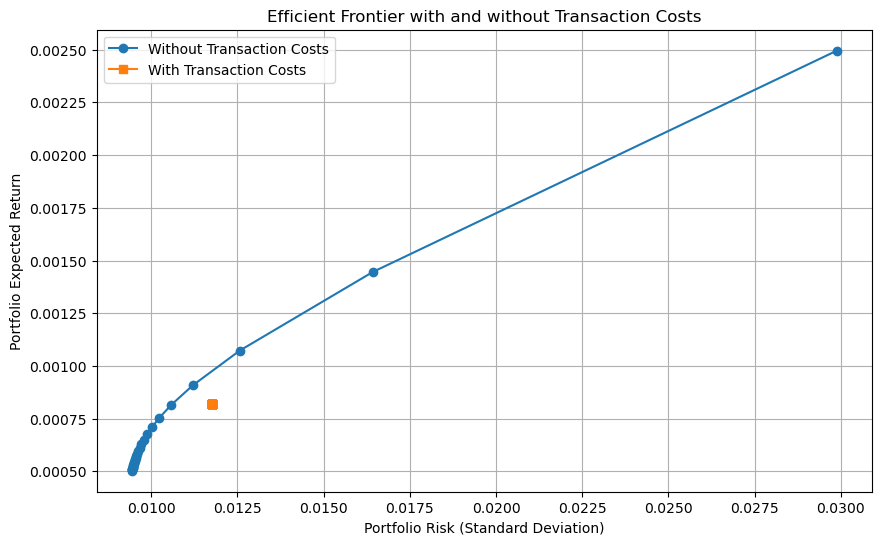

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(risks_no_costs, returns_no_costs, 'o-', label='Without Transaction Costs')
plt.plot(risks_with_costs, returns_with_costs, 's-', label='With Transaction Costs')

plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier with and without Transaction Costs')
plt.legend()
plt.grid(True)
plt.show()


## Model allowing short positions

\begin{align*}
    \text{Minimize} \quad & q\cdot \mathbf{x}^T \Sigma \mathbf{x} + \mathbf{r}^T\mathbf{x} \\
    \text{subject to} \quad \\
    & \mathbf{x} = \mathbf{x}_{\text{long}} - \mathbf{x}_{\text{short}}, \\
    & \mathbf{x}_{\text{long}} \succeq 0, \quad \mathbf{x}_{\text{short}} \succeq 0, \\
    & \mathbf{1}^T \mathbf{x}_{\text{short}} \leq \eta \mathbf{1}^T \mathbf{x}_{\text{long}}, \\
    & \mathbf{1}^T \mathbf{x} = 1
\end{align*}

In [22]:
class PortfolioWithShort(Portfolio):
    def calculate_optimal_with_short(self, eta=0.5):
        """
        Calculate the optimal portfolio weights allowing short positions.
        Args:
            eta (float): Maximum ratio of short positions to long positions (default is 0.5).
        Returns:
            tuple: Optimized portfolio weights, long positions, short positions.
        """
        x_long = cp.Variable(self.n)
        x_short = cp.Variable(self.n)
        x = x_long - x_short

        objective = cp.Minimize(self.q * cp.quad_form(x, self.sigma) - self.r @ x)
        constraints = [
            x_long >= 0,
            x_short >= 0,
            cp.sum(x_short) <= eta*cp.sum(x_long),
            cp.sum(x) == 1
        ]


        problem = cp.Problem(objective, constraints)
        result = problem.solve()

        return x.value, x_long.value, x_short.value

In [23]:
assets = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]  
port_short = PortfolioWithShort(assets,"10y",10)
opt_x = portfolio.calculate_optimal_x()
opt_x_combined, opt_x_long, opt_x_short = port_short.calculate_optimal_with_short(0.5)
print(f"Optimal x with no transaction costs: {opt_x}\n"
      f"Optimal x: {opt_x_combined}\n"
      f"Optimal x long position: {opt_x_long}\n"
      f"Optimal x short position: {opt_x_short}\n")

Optimal x with no transaction costs: [ 2.30481609e-02  4.19294678e-02  2.93866110e-02  6.95563393e-23
  2.99187283e-01  2.84376431e-01  1.31205503e-01  1.15520837e-01
 -1.60267664e-23  7.53457059e-02]
Optimal x: [ 0.04007936  0.13668004  0.00952762  0.04502033  0.28946483  0.25691079
  0.16028744  0.12536476 -0.04966322 -0.01367195]
Optimal x long position: [0.07078654 0.18943477 0.05677473 0.06383599 0.39271042 0.35072769
 0.18589886 0.13727664 0.02967048 0.03758581]
Optimal x short position: [0.03070718 0.05275473 0.04724711 0.01881566 0.1032456  0.09381689
 0.02561142 0.01191188 0.0793337  0.05125776]



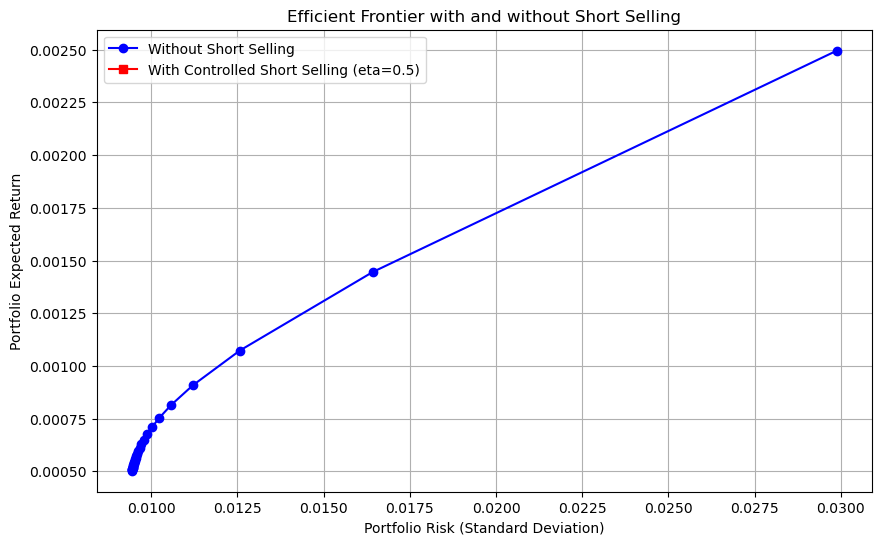

In [24]:
plt.figure(figsize=(10, 6))


plt.plot(risks_no_short, returns_no_short, 'o-', color='blue', label='Without Short Selling')

plt.plot(risks_with_short, returns_with_short, 's-', color='red', label='With Controlled Short Selling (eta=0.5)')

plt.title('Efficient Frontier with and without Short Selling')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## Model with Entropic Risk Measure

In [27]:
class PortfolioWithEntropicRisk(Portfolio):
    def calculate_optimal_with_entropicrisk(self):
        """
        Solve the entropic-risk minimization problem:
        
            minimize  (1/q)*log( (1/T)*∑ exp( -q * port_returns[t] ) )
            
        subject to:
            sum(weights) = 1
            weights >= 0
        
        Returns:
            np.ndarray: optimal weights (n, )
        """
        T, n = self.returns.shape
        
        x = cp.Variable(n, nonneg=True)
        
        port_ret = self.returns @ x
        
        mean_exp = cp.sum(cp.exp(-self.q * port_ret)) / T
        

        entropic_expr = (1.0 / self.q) * (cp.log_sum_exp(-self.q * port_ret) - np.log(T))
        
        objective = cp.Minimize(entropic_expr)
        
        constraints = [cp.sum(x) == 1]
        
        # Solve
        problem = cp.Problem(objective, constraints)
        result = problem.solve()
        
        if x.value is None:
            raise ValueError("No solution found.")
        
        return x.value

In [28]:
assets = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]  
opt_x = portfolio.calculate_optimal_x()
port_entropic = PortfolioWithEntropicRisk(assets,"10y",10)
opt_x_entropic = port_entropic.calculate_optimal_with_entropicrisk()
print(f"Optimal x: {opt_x}\n"
      f"Optimal x with entropic risk: {opt_x_entropic}\n")

Optimal x: [ 2.30481609e-02  4.19294678e-02  2.93866110e-02  6.95563393e-23
  2.99187283e-01  2.84376431e-01  1.31205503e-01  1.15520837e-01
 -1.60267664e-23  7.53457059e-02]
Optimal x with entropic risk: [4.87016354e-02 2.43511323e-01 3.98617159e-07 2.08513786e-02
 2.38449275e-01 1.68629753e-01 1.79556995e-01 1.00299117e-01
 4.06750964e-08 8.32011156e-08]



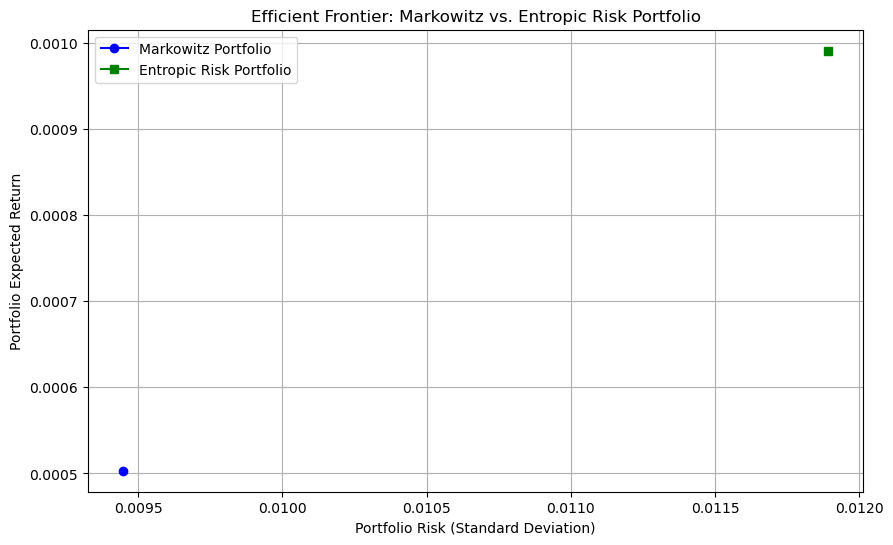

In [31]:
return_markowitz = opt_x @ portfolio.r
risk_markowitz = np.sqrt(opt_x.T @ portfolio.sigma @ opt_x)

return_entropic = opt_x_entropic @ port_entropic.r
risk_entropic = np.sqrt(opt_x_entropic.T @ port_entropic.sigma @ opt_x_entropic)


plt.figure(figsize=(10, 6))

plt.plot(risk_markowitz, return_markowitz, 'o-', label='Markowitz Portfolio', color='blue')
plt.plot(risk_entropic, return_entropic, 's-', label='Entropic Risk Portfolio', color='green')

plt.title('Efficient Frontier: Markowitz vs. Entropic Risk Portfolio')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.legend()
plt.grid(True)
plt.show()
